In [1]:
#%matplotlib inline
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn import tree
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score, roc_auc_score, mean_absolute_error
import seaborn as sns
import numpy as np
import glob
from fbprophet import Prophet
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold 
import matplotlib.pyplot
import pickle
from fbprophet.plot import plot_plotly as go
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.feature_selection import f_regression
from sklearn.naive_bayes import GaussianNB
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor

c:\Users\mpire\anaconda3\envs\prophetDH\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Considerando un dataset extraído de la api "oanda", que contiene el histórico de la variación por hora del valor de diferentes pares de monedas (EUR-USD, AUD-USD, etc), se propone lo siguiente: 


El trabajo está dividido en dos secciones: 
* Predicción de los retornos de las divisas EUR/USD utilizando modelos de regresión lineal y random forest con base en los retornos de los otros pares. Los datos fueron obtenidos de OANDA. 
* Predicción de la variación de la relación del precio de apertura de las monedas Euro -  Dólar haciendo uso de series de tiempo (forecasting). 

##  * Predicción de los retornos de las divisas EUR/USD utilizando modelos de regresión lineal y random forest con base en los retornos de los otros pares. Los datos fueron obtenidos de OANDA. 

## 1. Lectura del Dataframe 

In [2]:
csv_files = glob.glob("./*_H1.csv")

In [3]:
dataframes = {} # Crear dict vacío
keys_list = []  # Crear lista vacía

for file in csv_files:
    key = file.split(".\\")[1]
    key = key.replace("_H1.csv", "")  # Eliminar ".csv" del final de la clave
    dataframes[key] = pd.read_csv(file)
    keys_list.append(key)  # Agregar key a la lista

print(keys_list)

['AUD_USD', 'EUR_GBP', 'EUR_USD', 'GBP_USD', 'USD_CAD', 'USD_CHF', 'USD_JPY']


In [4]:
for key in dataframes:
    print(key, dataframes[key].shape)

AUD_USD (50000, 9)
EUR_GBP (50000, 9)
EUR_USD (50000, 9)
GBP_USD (50000, 9)
USD_CAD (50000, 9)
USD_CHF (50000, 9)
USD_JPY (50000, 9)


## 2. Descripción breve del DataFrame.

El DataFrame en estudio cuenta con 9  columnas y un total de 50000 filas. 

Las columnas contenidas en el DataFrame son: 

2.1 time: Hora en de apertura para cada periodo.

2.2 open_bid : Precio de apertura para la venta  a la hora indicada. 

2.3 high_bid : Precio más alto de venta del usuario para esa hora. 

2.4 low_bid : Precio más bajo de venta del usuario para esa hora.

2.5 close_bid: Precio de cierre para la venta a la hora indicada.

2.6 open_ask : Precio de apertura para la compra a la hora indicada. 

2.7 high_ask : Precio más alto de compra para el usuario para esa hora. 

2.8 low_ask : Precio más bajo de compra para usuario para esa hora.

2.9 close_ask : Precio de cierre para la compra a la hora indicada.

In [5]:
concatenated_df = pd.concat(dataframes.values(), axis=1)
opens = concatenated_df['open_bid']
opens.columns = keys_list

In [6]:
returns = np.log(opens/opens.shift(1))

# Descartar la primera fila (que contiene valores NaN debido al desplazamiento)
returns = returns.iloc[1:]

# Mostrar los retornos
returns

,AUD_USD,EUR_GBP,EUR_USD,GBP_USD,USD_CAD,USD_CHF,USD_JPY
1,0.000088,-0.000442,-0.000071,0.000178,0.000248,-0.000221,0.000093
2,-0.000554,0.000522,0.000565,0.000929,0.000112,0.003191,-0.001973
3,-0.001034,-0.000281,-0.000362,-0.001397,0.000750,-0.004696,0.000511
4,-0.000745,0.001457,0.001639,0.001707,-0.001461,-0.001884,-0.000323
5,0.009138,0.000401,0.001294,0.000375,0.000926,-0.001699,0.000987
...,...,...,...,...,...,...,...
49995,-0.000980,-0.000248,-0.000373,-0.000140,0.000713,0.000434,0.000350
49996,0.000260,-0.000779,0.000158,-0.000091,-0.000981,-0.001074,-0.000486
49997,0.000101,0.000599,0.000438,0.000215,0.000089,0.000163,-0.000981
49998,0.000476,0.000745,-0.000065,-0.000231,-0.000037,0.000228,0.000677


In [7]:
returns.to_csv('returns.csv')

### Consideremos la matriz de correlacion para las features y la target

In [8]:
corr_matrix = returns.corr().abs()

corr_matrix

,AUD_USD,EUR_GBP,EUR_USD,GBP_USD,USD_CAD,USD_CHF,USD_JPY
AUD_USD,1.000000,0.023534,0.114771,0.140486,0.095499,0.081279,0.091711
EUR_GBP,0.023534,1.000000,0.242374,0.075940,0.023559,0.013573,0.020492
EUR_USD,0.114771,0.242374,1.000000,0.180636,0.072282,0.108194,0.130609
GBP_USD,0.140486,0.075940,0.180636,1.000000,0.092200,0.115196,0.104549
USD_CAD,0.095499,0.023559,0.072282,0.092200,1.000000,0.084583,0.068163
USD_CHF,0.081279,0.013573,0.108194,0.115196,0.084583,1.000000,0.096968
USD_JPY,0.091711,0.020492,0.130609,0.104549,0.068163,0.096968,1.000000


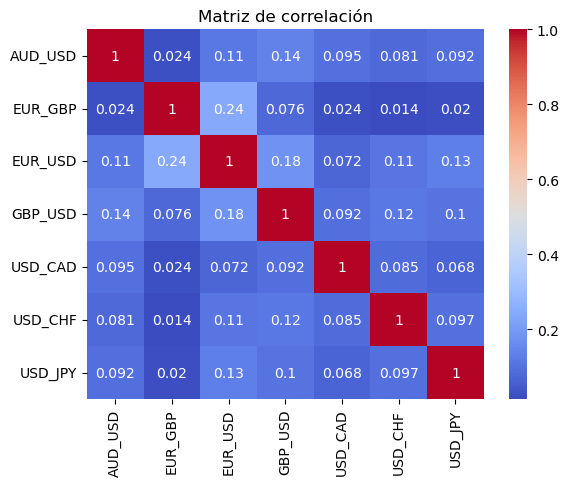

In [9]:
# Gráfica de la matríz de correlación

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()

In [10]:
# Seleccionemos la mejor columna a predecir

best_column = corr_matrix.iloc[:-1, -1].idxmax()

print("La mejor columna para predecir es:", best_column)

La mejor columna para predecir es: EUR_USD


In [11]:
# Definir las variables independientes (predictoras) y la variable dependiente (objetivo)

X = returns.drop(best_column, axis=1)
y = returns[best_column]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [12]:
# Implementando la técnica de regresión lineal más conocida (OLS), mínimos cuadrados ordinarios:

X = sm.add_constant(X)
    
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                EUR_USD   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     1207.
Date:                Sun, 26 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:27:37   Log-Likelihood:             2.7405e+05
No. Observations:               49999   AIC:                        -5.481e+05
Df Residuals:                   49992   BIC:                        -5.480e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.544e-07   4.51e-06     -0.190      0.8

###### - El valor de R-cuadrado es 0.127, lo que significa que el modelo explica el 12.7% de la variabilidad de los datos.

###### - El p-valor en este caso, todos los coeficientes tienen un p-valor menor que 0.05, lo que indica que son estadísticamente significativos.


In [13]:
# Ahora aplicando el modelo de regresión lineal múltiple en el conjunto de entrenamiento:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predecir los valores del conjunto de prueba
y_pred = regressor.predict(X_test)

# imprimimos los coeficientes del modelo y el intercepto
print('Coeficientes:', regressor.coef_)
print('Intercepto:', regressor.intercept_)

Coeficientes: [ 0.06372376  0.24606895  0.13893988 -0.05604398 -0.07642807 -0.09962549]
Intercepto: -3.921666003094603e-06


In [14]:
# Calcular las métricas de rendimiento del modelo en el conjunto de prueba
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f"El error cudrático medio R^2 es: {r2:.3F}")
print(f"La raíz cuadrada del R2 (MSE) es: {mse:.3F}")
print(f"El error absoluto medio (MAE) es: {mae:.4F}")

El error cudrático medio R^2 es: 0.121
La raíz cuadrada del R2 (MSE) es: 0.001
El error absoluto medio (MAE) es: 0.0007


El valor de R2 es 0.121, lo que indica que el modelo explica solo el 12.1% de la varianza en los datos de prueba. Este valor no es muy alto y sugiere que el modelo no es muy efectivo en la predicción de los valores de la variable dependiente.

El valor de MSE es 0.001, lo que indica que el modelo tiene una precisión razonable en la predicción de los valores de la variable dependiente.

El valor de MAE es 0.0007, lo que indica que el modelo tiene una precisión razonable en la predicción de los valores de la variable dependiente.

En general, aunque el modelo tiene una precisión razonable en la predicción de los valores de la variable dependiente (como se indica por los valores bajos de MSE y MAE), el bajo valor de R2 sugiere que el modelo no es muy efectivo en la explicación de la varianza en los datos de prueba.

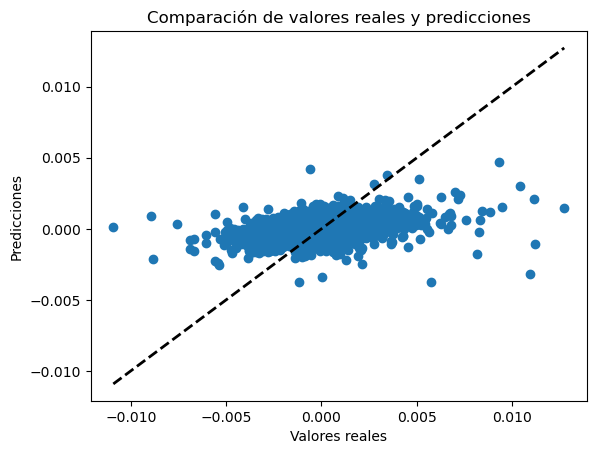

In [15]:
# Visualizar las predicciones del modelo en comparación con los valores reales
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Comparación de valores reales y predicciones')
plt.show()

##### Implementando Pipeline

In [16]:
# Pipeline + GridSearch

# Definir los preprocesadores y el modelo
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Definir los hiperparámetros para GridSearch
param_grid = {
    'regressor__n_estimators': [10, 50, 100],
    'regressor__max_depth': [None, 5, 10],
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}

# Realizar la búsqueda de hiperparámetros
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X, y)

# Imprimir los mejores hiperparámetros y score de validación cruzada
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Mejor score de validación cruzada:", grid_search.best_score_)

# Predecir el resultado para los datos de prueba y calcular métricas de evaluación
y_pred = grid_search.predict(X)
print("R2 score:", r2_score(y, y_pred))
print("Mean absolute error:", mean_absolute_error(y, y_pred))

c:\Users\mpire\anaconda3\envs\prophetDH\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\mpire\anaconda3\envs\prophetDH\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
c:\Users\mpire\anaconda3\envs\prophetDH\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as i

Mejores hiperparámetros encontrados: {'regressor__max_depth': 5, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 10}
Mejor score de validación cruzada: 0.0065307216561858675
R2 score: 0.1523758169280558
Mean absolute error: 0.0006487297120018296


###### - La primera línea define el modelo de regresión como una tubería (pipeline) que aplica una escala de características estándar (StandardScaler()) y luego entrena un modelo de bosques aleatorios (RandomForestRegressor()).
###### - La segunda línea define una cuadrícula de hiperparámetros para la búsqueda, donde se especifican las opciones para el número de árboles (n_estimators), la profundidad máxima del árbol (max_depth) y el número máximo de características consideradas para cada división (max_features).
###### - La tercera línea realiza la búsqueda de hiperparámetros utilizando validación cruzada de 5 pliegues (cv=5).
###### - Las dos líneas siguientes imprimen los mejores hiperparámetros encontrados y el puntaje (score) de validación cruzada correspondiente. El mejor puntaje de validación cruzada se refiere al promedio del rendimiento del modelo en los diferentes pliegues de validación cruzada.
###### - Las últimas tres líneas utilizan el modelo entrenado con los mejores hiperparámetros encontrados para hacer predicciones sobre el conjunto de datos de entrenamiento X. Luego se imprimen dos métricas de evaluación del rendimiento del modelo: el coeficiente de determinación R cuadrado (r2_score) y el error absoluto medio (mean_absolute_error).
###### Los resultados de la búsqueda de hiperparámetros indican que el mejor conjunto de hiperparámetros encontrado incluye 10 árboles, una profundidad máxima de 5 y el número máximo de características por división de sqrt (raíz cuadrada). Además, el puntaje de validación cruzada obtenido es muy bajo, lo que sugiere que el modelo no es muy bueno en general para predecir los valores objetivo. Las métricas de evaluación indican un bajo rendimiento del modelo en el conjunto de entrenamiento, con un valor de R cuadrado de 0.15 y un error absoluto medio muy bajo.

### Para generación de pickles

In [17]:
#with open ('regressor.pkl', 'wb') as f: 

#    pickle.dump(regressor, f)

In [18]:
#with open ('grid_search.pkl', 'wb') as f:
#    pickle.dump(grid_search, f)

-------------------------------------------------------------------------------------------------------------------

## 2. * Predicción de la variación de la relación del precio de apertura de las monedas Euro -  Dólar haciendo uso de series de tiempo (forecasting). 

###  REGENERACIÓN DEL DATASET DE ENTRADA PARA EL MODELO USANDO SERIE DE DATOS

## 1. Lectura del Dataframe 

In [19]:
datos = pd.read_csv(r'EUR_USD_H1.csv')
print(datos.head)
print(f'El dataframe que se construye con las variaciones de cotización de par de moneda (Euro-Dólar) está compuesto por {datos.shape[1]} columnas y {datos.shape[0]} filas') 

<bound method NDFrame.head of                    time  open_bid  high_bid  low_bid  close_bid  open_ask  \
0      2015-01-28 02 AM   1.13343   1.13398  1.13299    1.13338   1.13358   
1      2015-01-28 03 AM   1.13335   1.13429  1.13335    1.13397   1.13352   
2      2015-01-28 04 AM   1.13399   1.13413  1.13317    1.13362   1.13414   
3      2015-01-28 05 AM   1.13358   1.13632  1.13329    1.13547   1.13373   
4      2015-01-28 06 AM   1.13544   1.13815  1.13524    1.13693   1.13561   
...                 ...       ...       ...      ...        ...       ...   
49995  2023-02-09 09 PM   1.07328   1.07380  1.07323    1.07380   1.07342   
49996  2023-02-09 10 PM   1.07345   1.07408  1.07345    1.07391   1.07421   
49997  2023-02-09 11 PM   1.07392   1.07412  1.07373    1.07384   1.07434   
49998        2023-02-10   1.07385   1.07386  1.07248    1.07341   1.07402   
49999  2023-02-10 01 AM   1.07340   1.07349  1.07304    1.07339   1.07355   

       high_ask  low_ask  close_ask  
0      

In [20]:
df = datos[['open_bid', 'time']]
df.head()

,open_bid,time
0,1.13343,2015-01-28 02 AM
1,1.13335,2015-01-28 03 AM
2,1.13399,2015-01-28 04 AM
3,1.13358,2015-01-28 05 AM
4,1.13544,2015-01-28 06 AM


In [21]:
# Cambio de columna a datetime
df['time'] = pd.to_datetime(df['time'])
df.index = df.time
df_ARIMA = df.drop(['time'], axis = 1)


C:\Users\mpire\AppData\Local\Temp\ipykernel_5372\418822103.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'])


In [22]:
# Resample del DataFrame , calculando open_bid promedio por día. 
exchange_rate_1 = df_ARIMA.resample('D').agg({'open_bid':'mean'})
exchange_rate_1

,open_bid
time,
2015-01-28,1.133460
2015-01-29,1.130125
2015-01-30,1.131697
2015-01-31,NaN
2015-02-01,1.130895
...,...
2023-02-06,1.076015
2023-02-07,1.072053
2023-02-08,1.073121


In [23]:
# Para saber si existen valores nulos
exchange_rate_1.isnull().sum()

open_bid    429
dtype: int64

In [24]:
# Eliminar valores nulos 
exchange_rate = exchange_rate_1.dropna()

In [25]:
df2 = exchange_rate.reset_index()

In [26]:
df2.head()

,time,open_bid
0,2015-01-28,1.133460
1,2015-01-29,1.130125
2,2015-01-30,1.131697
3,2015-02-01,1.130895
4,2015-02-02,1.132493


## 3. Distribución de los datos 

<AxesSubplot:>

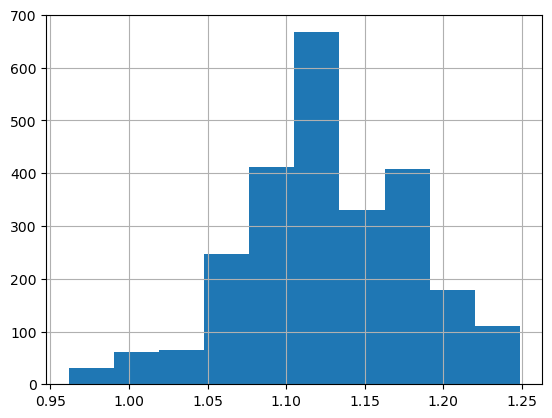

In [27]:
df2.open_bid.hist()

### Variación temporal de la relación del precio de apertura entre EUR-USD

In [28]:
fig = px.line(df2, x = df2.time, y = df2.open_bid, template = "plotly_dark",
            title = 'Variación de precio de apertura entre EUR y USD')
fig.show()

### División en train y test 

In [29]:
#Usaremos el 70% de los datos para train y el restante para test. 

training_data, testing_data = train_test_split(df2, test_size=0.3, random_state=42, shuffle=False)

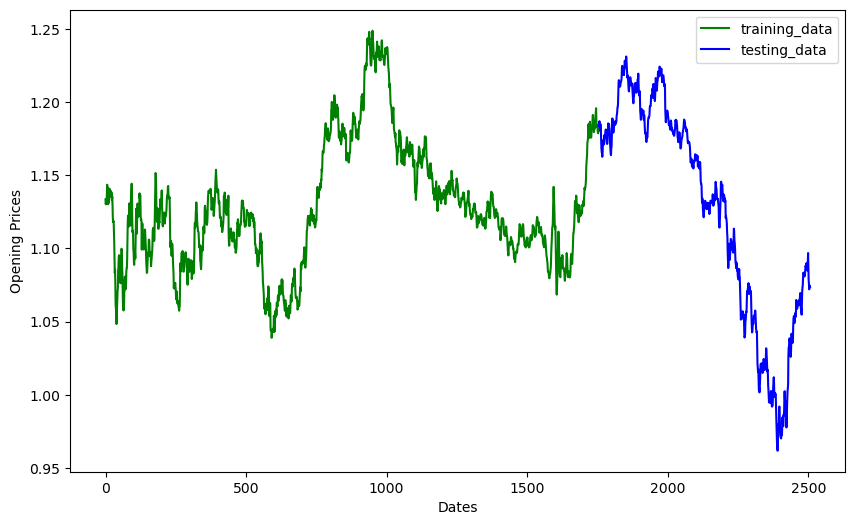

In [30]:
# Para ver gráficamente los datos de train y test

plt.figure(figsize=(10,6))
plt.grid=(True)
plt.xlabel('Dates')
plt.ylabel('Opening Prices')
plt.plot(training_data['open_bid'], 'green', label = 'training_data')
plt.plot(testing_data['open_bid'], 'blue', label = 'testing_data')
plt.legend()

In [31]:
testing_data.head()

,time,open_bid
1754,2020-09-11,1.183865
1755,2020-09-13,1.183790
1756,2020-09-14,1.185861
1757,2020-09-15,1.186879
1758,2020-09-16,1.183972


### Preparación de los datos para modelo de series de tiempo 

In [32]:
training_data.rename(columns={'time': 'ds', 'open_bid': 'y'}, inplace=True)
train_data = training_data.sample(frac=0.8, random_state=10)
validation_data = training_data.drop(train_data.index)

print(f'training data size : {train_data.shape}')
print(f'validation data size : {validation_data.shape}')

train_data = train_data.reset_index()
validation_data = validation_data.reset_index()

training data size : (1403, 2)
validation data size : (351, 2)


In [33]:
training_data

,ds,y
0,2015-01-28,1.133460
1,2015-01-29,1.130125
2,2015-01-30,1.131697
3,2015-02-01,1.130895
4,2015-02-02,1.132493
...,...,...
1749,2020-09-06,1.184007
1750,2020-09-07,1.182413
1751,2020-09-08,1.179552
1752,2020-09-09,1.178632


### Entrenando el modelo

In [34]:
model_exchange = Prophet(daily_seasonality=True)
model_exchange.fit(training_data)

c:\Users\mpire\anaconda3\envs\prophetDH\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [35]:
# Guardar el modelo
# with open('exchange.pkl', 'wb') as f:
#    pickle.dump(model_exchange, f)

## Haciendo predicciones sobre el conjunto de validación

In [36]:
prediction = model_exchange.predict(pd.DataFrame({'ds':validation_data['ds']}))
y_actual = validation_data['y']
y_predicted = prediction['yhat']
print(f'Mean absolute error es {mean_absolute_error(y_actual, y_predicted)}')

c:\Users\mpire\anaconda3\envs\prophetDH\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\Users\mpire\anaconda3\envs\prophetDH\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Mean absolute error es 0.009895208933272543


In [37]:
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-28,1.130448,1.119238,1.150699,1.130448,1.130448,0.004583,0.004583,0.004583,0.00802,...,0.000068,0.000068,0.000068,-0.003504,-0.003504,-0.003504,0.0,0.0,0.0,1.135031
1,2015-01-30,1.129663,1.117886,1.149887,1.129663,1.129663,0.004539,0.004539,0.004539,0.00802,...,0.000214,0.000214,0.000214,-0.003695,-0.003695,-0.003695,0.0,0.0,0.0,1.134201
2,2015-02-02,1.128484,1.116640,1.148015,1.128484,1.128484,0.004034,0.004034,0.004034,0.00802,...,0.000184,0.000184,0.000184,-0.004170,-0.004170,-0.004170,0.0,0.0,0.0,1.132518
3,2015-02-03,1.128092,1.116494,1.148123,1.128092,1.128092,0.003804,0.003804,0.003804,0.00802,...,0.000166,0.000166,0.000166,-0.004382,-0.004382,-0.004382,0.0,0.0,0.0,1.131896
4,2015-02-12,1.124557,1.108686,1.141135,1.124557,1.124557,0.000765,0.000765,0.000765,0.00802,...,0.000412,0.000412,0.000412,-0.007667,-0.007667,-0.007667,0.0,0.0,0.0,1.125321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,2020-08-16,1.129537,1.146675,1.178073,1.129537,1.129537,0.033602,0.033602,0.033602,0.00802,...,-0.000042,-0.000042,-0.000042,0.025625,0.025625,0.025625,0.0,0.0,0.0,1.163140
347,2020-08-18,1.129803,1.149052,1.181231,1.129803,1.129803,0.034750,0.034750,0.034750,0.00802,...,0.000166,0.000166,0.000166,0.026564,0.026564,0.026564,0.0,0.0,0.0,1.164553
348,2020-08-30,1.131393,1.154127,1.186630,1.131393,1.131393,0.039445,0.039445,0.039445,0.00802,...,-0.000042,-0.000042,-0.000042,0.031468,0.031468,0.031468,0.0,0.0,0.0,1.170839
349,2020-09-01,1.131658,1.154947,1.188103,1.131658,1.131658,0.039977,0.039977,0.039977,0.00802,...,0.000166,0.000166,0.000166,0.031791,0.031791,0.031791,0.0,0.0,0.0,1.171635


In [38]:
validation_data.head()

,index,ds,y
0,0,2015-01-28,1.133460
1,2,2015-01-30,1.131697
2,4,2015-02-02,1.132493
3,5,2015-02-03,1.139066
4,13,2015-02-12,1.135059


In [39]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=validation_data['ds'], y=y_actual, name="actual targets"),
    secondary_y=False,)
fig.add_trace(
    go.Scatter(x=validation_data['ds'], y=y_predicted, name="predicted targets"),
    secondary_y=True,)
fig.update_layout(
    title_text="Actual vs Predicted Targets")
fig.update_xaxes(title_text="Timeline")
fig.update_yaxes(title_text="actual targets", secondary_y=False)
fig.update_yaxes(title_text="predicted targets", secondary_y=True)
fig.show()

In [40]:
test_prediction = model_exchange.predict(pd.DataFrame({'ds':testing_data['time']}))

c:\Users\mpire\anaconda3\envs\prophetDH\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\Users\mpire\anaconda3\envs\prophetDH\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [41]:
test_prediction.yhat

0      1.171627
1      1.170902
2      1.170864
3      1.170568
4      1.170182
         ...   
748    1.252389
749    1.252173
750    1.251845
751    1.251927
752    1.251432
Name: yhat, Length: 753, dtype: float64

In [42]:
testing_data_2 = testing_data.reset_index(drop=True)

In [43]:
testing_data_2['pred'] = test_prediction.yhat

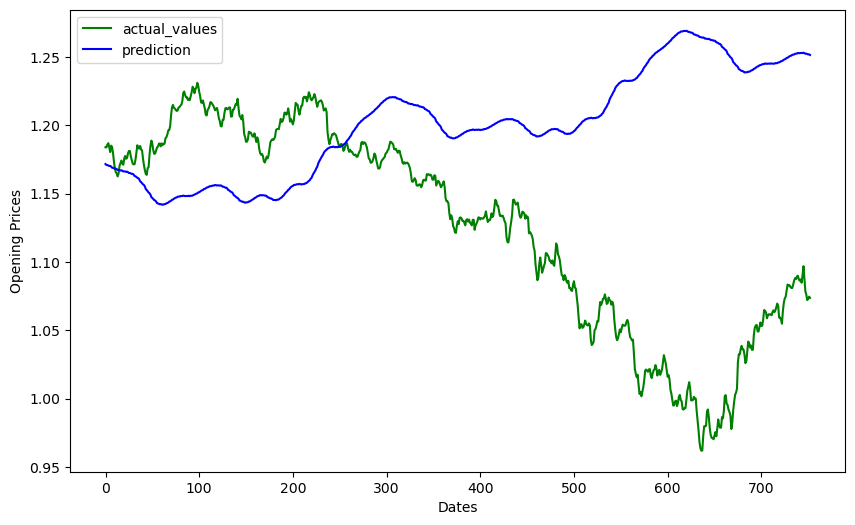

In [44]:
# Para ver gráficamente los datos de predicción
plt.figure(figsize=(10,6))
plt.grid=(True)
plt.xlabel('Dates')
plt.ylabel('Opening Prices')
plt.plot(testing_data_2['open_bid'], 'green', label = 'actual_values')
plt.plot(testing_data_2['pred'], 'blue', label = 'prediction')
plt.legend()

In [45]:
testing_data_2.to_csv('predicciones_monedas.csv', index=False)